#  Импорт


In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных


# Данные

Наши старые друзья / знакомые


In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для классификации
    Входные переменные:
    ===========
    ax: отдельная ячейка объекта figure
    ds: набор данных, содержащий признаки X и целевые метки y
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """

    X, y = ds # распаковываем признаки и целевые метки в отдельные переменные

    cm_bright = ListedColormap(colors) # формируем цветовую карту из наших цветов
    ax.set_title(name, fontsize = 30) # прописываем название графика
    if facecolor: # если переменная задана, то просто рисуем скатерограмму по признакам с использованием параметров маркеров
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else: # иначе так же рисуем скатерограмму, но без
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
    # немного красоты и аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42,):
    """Создание синтетического набора данных
    для бинарной классификации
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        # если выбран метод line (или никакой не задан)
        # то мы создаем набор данных с использованием функции make_classification
        # это будут линейно-разделимые данные
        X, y = make_classification(n_samples=N, # количество точек
                                   n_features=2, # количество признаков
                                   n_redundant=0, # количество бесполезных признаков
                                   n_informative=2,# количество информативных признаков
                                   n_clusters_per_class=1, # количество групп точек на класс
                                   class_sep=2, # количество классов
                                   random_state=random_state # фиксированный сид случайных чисел
                                   )
        X += np.random.randn(*X.shape) *noises # добавляем к признакам случайный шум

    elif method == 'moons':
        # если выбран метод moons
        # то мы создаем набор данных с использованием функции make_moons
        # это будут данные похожие на Инь-Ян
        X, y = make_moons(n_samples=N, # количество точек
                          noise=noises, # уровень шума
                          random_state=random_state # фиксированный сид случайных чисел
                          )

    elif method == 'circles':
        # если выбран метод circles
        # то мы создаем набор данных с использованием функции make_circles
        # это будут данные в виде концентрических окружностей
        X, y = make_circles(n_samples=N, # количество точек
                            noise=noises, # уровень шума
                            factor=0.5, # соотношение радиусов внуренней и внешней окружности
                            random_state=random_state # фиксированный сид случайных чисел
                            )


    return X,y

In [ ]:
#@title данные { run: "auto" }
N = 150 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,method = 'line',
                             noises = noises),
          'Линейно разделимые')
ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons',
                             noises = noises),
          'Инь-Ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles',
                              noises = noises),
          'Круги')




За неимением лучшего аналога тестировать алгоритмы кластеризации будем на тех же наборах, что и классификацию

# EM-Кластеризация

Начнем по традиции с простых данных - линейно разделимых

In [ ]:
N = 150
X,y = make_binary_clf(N,method = 'line', noises=0.05, )

X.shape

(150, 2)

In [ ]:
from sklearn.mixture import GaussianMixture # EM-Кластеризация со смесью Гауссиан  от Scikit-learn

По традиции мы сначала создаем объект нужного нам класса, в котором мы можем изменять гиперпараметры

В случае EM-Кластеризации со смесью Гауссиан рекомендуется варьировать

*   количество кластеров `n_components`
*   тип матрицы ковариации `cov_type`
 * `'full'`: каждая компонента имеет свою полную ковариационную матрицу
 * `'tied'`: все компоненты имеют одну и ту же полную ковариационную матрицу
 * `'diag'`: каждая компонента имеет свою диагональную ковариационную матрицу
 * `'spherical'`: каждая компонента имеет свою единственную дисперсию



In [ ]:
# Создаем Класс ЕМ-Кластеризации со смесью моделей Гауссиан
gm = GaussianMixture(n_components=2,
                     covariance_type = 'full')

gm

GaussianMixture(n_components=2)

Традиционно обучаем методом `.fit()`

In [ ]:
gm.fit(X);

В аттрибуте `.means_`хранятся координаты центров кластеров (средние значения в нормальном распределении)

In [ ]:
gm.means_

array([[ 1.96310676,  2.07391006],
       [-2.09030629,  1.9105176 ]])

В аттрибуте `.covariances_`хранится матрица ковариации (в зависимости от заданного типа)

In [ ]:
gm.covariances_

array([[[ 0.17701169, -0.41771644],
        [-0.41771644,  1.01600453]],

       [[ 1.16619278,  0.08510035],
        [ 0.08510035,  0.31490616]]])

Предсказание - по традиции методом `.predict()`

In [ ]:
labels = gm.predict(X)

## Визуализация результатов

Визуализация Эллипсов

In [ ]:
import matplotlib as mpl # библиотека Matplotlib для визуализации

def make_ellipses(gmm, ax, colors):

    """Отрисовка элипсов, описывающих кластеры
    Входные переменные:
    ===========
    gmm: обученный класс EM-кластеризации
    ax: полотно, на котором мы будем рисовать
    colors: цвета для каждого кластера
    """
    for n, color in enumerate(colors): # перебираем все цвета (кластеры)
        # проверяем какой тим матрицы ковариации мы вабрали
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

        # ищем собственные значения (v) и собственные вектора (w) матрицы ковариации
        v, w = np.linalg.eigh(covariances)

        # нормируем собственные вектора
        u = w[0] / np.linalg.norm(w[0])

        # находим угол наклона
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi
        # нормируем собственные значения
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

        # отрисовываем объект типа Ellipse
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], # координаты центра
            v[0],  # ширина эллипса
            v[1], # высота эллипса
            angle= 180 + angle, # угол наклона эллипса
            fc=color, # цвет заполнения эллипса
            ec = 'k' # цвет края - черный
        )
        ell.set_clip_box(ax.bbox) # согласуем огнаничения эллипса с ограничением полотна
        ell.set_alpha(0.8) # прозрачность
        ax.add_artist(ell) #добавляем объект на полотно
        ax.set_aspect("equal", "datalim")

* Сначала создаем полотно, в котором отрисовываем скатерограмму данных

* Затем добавляем на неё визуализацию эллипсов для каждого кластеров

In [ ]:
def plot_em_clustering(X, gmm):
    """Отрисовка элипсов, описывающих кластеры
    Входные переменные:
    ===========
    X: данные, на которых мы хотим построить визуализацию
    gmm: обученный класс EM-кластеризации
    """
    labels = gm.predict(X) # предсказываем метки кластеров
    ax = plt.subplot(1, 1, 1) # создаем полотно
    # отрисовываем скатерограмму
    sc = ax.scatter(X[:, 0], X[:, 1], # данные
                    c=labels,  # подкрашиваем по предсказанным меткам
                    alpha = 0.6, # прозрачность
                    cmap = 'bwr', # тип цветовой карты
                    edgecolor = 'k', # цвет края - черный
                    s = 100  # размер
                    )

    # Создаем список из цветов
    colors = []
    # Для каждой метки класстеров
    markers = np.unique(labels)
    # Цвета подбираются таким же как и цветовая карта на скатерорамме
    for c in markers:
        colors.append(sc.to_rgba(c))

    # Воспользуемся написанной выше функцией для визуализации эллипсов
    make_ellipses(gmm, ax, colors)

    plt.xticks([],[])
    plt.yticks([],[])

Применяем написанную выше функцию

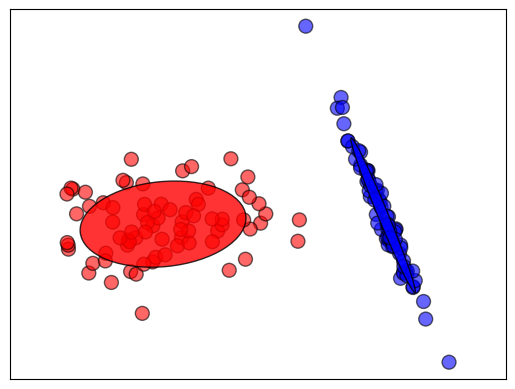

In [ ]:
plot_em_clustering(X, gm)

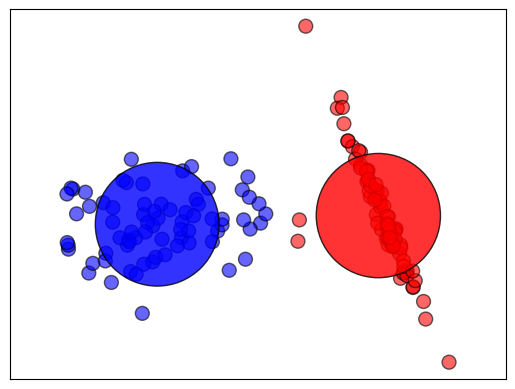

In [ ]:
#@title Применение EM-Кластеризации  { run: "auto" }
#@markdown ### потенциальное число кластеров
n_components = 2 #@param {type:"slider", min:2, max:10, step:1}
#@markdown ### тип матрицы ковариации
cov_type = "spherical" #@param ["spherical", "diag", "tied", "full"]{type:"string"}


# Создаем Класс ЕМ-Кластеризации со смесью моделей Гауссиан
gm = GaussianMixture(n_components=n_components,
                     covariance_type = cov_type)

# Обучаем Класс
gm.fit(X)

# Визуализируем
plot_em_clustering(X, gm)


# Задание

Проверить алгоритм EM-Кластеризации на данных Инь-Ян  и Круги

In [ ]:
N = 150
X_circle,y_circle = make_binary_clf(N,method = 'circles', noises=0.05, )
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X_circle,y_circle))

In [ ]:
N = 150
X_moons,y_moons = make_binary_clf(N,method = 'moons', noises=0.05, )
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X_moons,y_moons))